# QSVM
Quantum Support Vector Machines is the Quantum version of SVM - a data classification method which separates the data using a hyperplane.

This algorithm takes the following steps:
- Map the data into a different hyperspace (since the data may be non-linearly-seperable in the original space)
    - In the case of QSVM - mapping the classical data into Hilbert space.
- Calculate the kernel matrix
    - The kernel entries are the fidelities between different feature vectors
    - In the case of QSVM - this is done on a Quantum computer.
- Optimize the dual problem (this is always done classicaly)
$$ L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\vec{x}_i \vec{x}_j) $$
    - Where $t$ is the amount of data points
    - the $\vec{x}_i$s are the data points
    - $y_i$ is the label $\in \{-1,1\}$ of each data point
    - $K(\vec{x}_i \vec{x}_j)$ is the kernel matrix element between the $i$ and $j$ datapoints
    - and we optimize over the $\alpha$s
    - We expect most of the $\alpha$s to be $0$. The $\vec{x}_i$s that correspond to non-zero $\alpha_i$ are called the Support Vectors.
- Finally, we may predict unlabeled data by calculating the kernel matrix of the new datum with respect to the support vectors
$$ \text{Predicted Label}(\vec{s}) = \text{sign} \left( \sum_{i=1}^t y_i \alpha_i^* K(\vec{x}_i , \vec{s}) + b \right) $$
    - Where $\vec{s}$ is the datapoint to be classified
    - $\alpha_i^*$ are the optimized $\alpha$s
    - And $b$ is the bias.


Reference:

[1] Havl&#237;&#269;ek, V., C&#243;rcoles, A.D., Temme, K. et al. Supervised learning with quantum-enhanced feature spaces. Nature 567, 209-212 (2019). https://doi.org/10.1038/s41586-019-0980-2

# Code
First, we start with the relevant imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import construct_qsvm_model, execute, show, synthesize
from classiq.applications.qsvm import QSVMFeatureMapEntanglement

## Classiq imports

Next, we generate data.

In this example, we take a 2D input space, and a binary classification (i.e. only 2 groups of data points)

In [2]:
import random

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Importing functions used for this demo, to generate random linearly separable data
from classiq.applications.qsvm.qsvm_data_generation import (
    data_and_labels_to_data_dict,
    data_dict_to_data_and_labels,
    generate_data,
)

# Generate sample data:
sources = np.array([[1.23016026, 1.72327701], [3.20331931, 5.32365722]])

training_input: dict = generate_data(sources=sources)
test_input: dict = generate_data(sources=sources)
predict_input, predict_real_labels = data_dict_to_data_and_labels(
    generate_data(sources=sources)
)

Plotting the data.

Note that the data is expected to be normalized to within $ 0 $ to $ 2 \pi $.

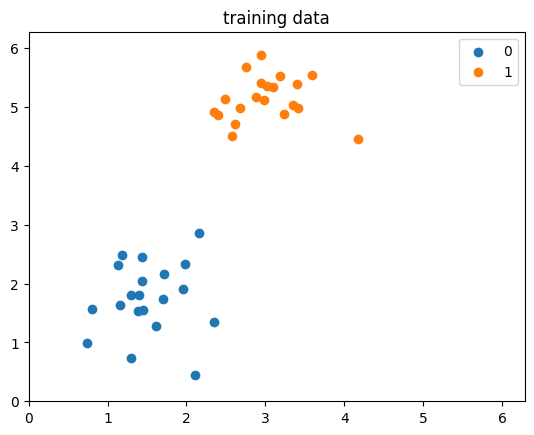

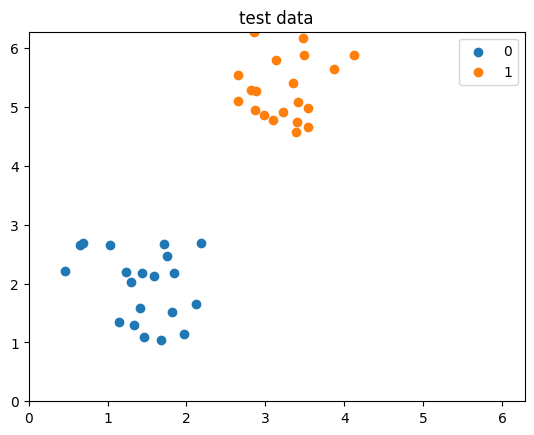

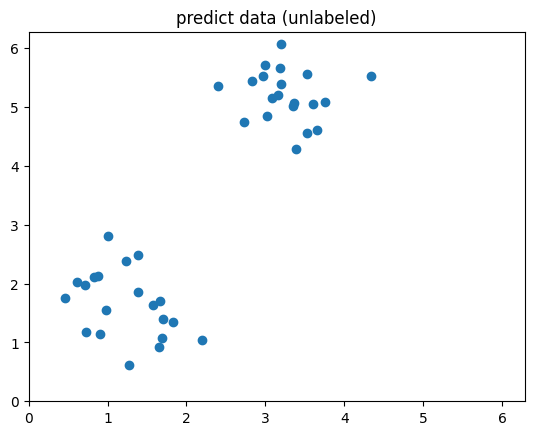

In [4]:
# Plot the data
plot_range = (0, 2 * np.pi)

for k, v in training_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("training data")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

for k, v in test_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("test data")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

plt.scatter(*predict_input.T)
plt.title("predict data (unlabeled)")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

### Define our Feature Map
When constructing a `QSVM` model, one must supply which feature map will be used.

A feature map is a way to encode classical data into quantum.
Here, we chose to encode the data onto the surface of the bloch sphere.
Behind the scenes, this can be translated to:
```
R_X(x[0] / 2)
R_Z(x[1])
```
Where `x` is the 2D input vector, and the circuit takes a single qubit per data-point.

In [5]:
bloch_sphere_feature_map_function_name = "bloch_sphere_feature_map"
bloch_sphere_kwargs = {"bloch_feature_dimension": 2}

### Define the Data
I addition to the feature map, we need to prepare our data.

The `train_input` and `test_input` datasets consisting of data and its labels. The labels is a 1D array where the value of the label correspond to each data point and can be basically anything - such as (0, 1) , (3, 5) , or ('A', 'B').
The `predict_input` consists only of data point (without labels).


In [6]:
# Prepare and define `train_input` and `test_input` datasets consisting of data and labels
TRAIN_DATA, TRAIN_LABEL = data_dict_to_data_and_labels(training_input)
TEST_DATA, TEST_LABEL = data_dict_to_data_and_labels(test_input)

# Prepare and define `predict_input`
PREDICT_DATA = predict_input

### Construct a model
We can now construct the QSVM model using the `construct_qsvm_model` function:

In [7]:
QSVM_BLOCH_SHPERE = construct_qsvm_model(
    train_data=TRAIN_DATA.tolist(),
    train_labels=TRAIN_LABEL.tolist(),
    test_data=TEST_DATA.tolist(),
    test_labels=TEST_LABEL.tolist(),
    predict_data=PREDICT_DATA.tolist(),
    feature_map_function_name=bloch_sphere_feature_map_function_name,
    **bloch_sphere_kwargs
)

In [8]:
from classiq import write_qmod

write_qmod(QSVM_BLOCH_SHPERE, "qsvm")

### Synthesize our model and explore the generated quantum circuit
Once we constructed our qsvm model - we synthesize and view the quantum circuit that encodes our data.
For this we will use `classiq` built-in `synthesize` and `show` functions:

In [9]:
qprog = synthesize(QSVM_BLOCH_SHPERE)
show(qprog)

Opening: https://platform.classiq.io/circuit/9ef21bd7-bab7-4fd0-9e12-94f1cadce438?version=0.41.0.dev39%2B79c8fd0855


### Execute QSVM
The first step in QSVM is the training.
The second step in QSVM is to test the training process.
The last QSVM step, which may be applied multiple times on different datasets, is prediction: the prediction process takes unlabeled data, and returns its predicted labels.

Executing QSVM is done though the `execute` function.
The execution results will include the accuracy of the classification and the predicted labels for the predict data.


In [10]:
results = execute(qprog).result()

We can view the classification accuracy through `test_score`

In [11]:
results[0].value["test_score"]

1.0

Since this data was previously generated, we also know the real labels, and can print them for comparison.

In [12]:
predicted_labels = results[0].value["predicted_labels"]
print(predicted_labels)
print(predict_real_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


We can even visualize the predicted results:

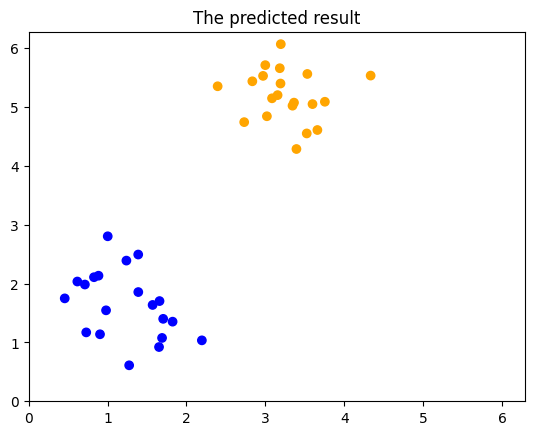

In [13]:
# Plotting
COLORS = ["blue", "orange"]
plt.scatter(
    *zip(*predict_input),
    color=np.vectorize(COLORS.__getitem__)(predicted_labels),
)
plt.title("The predicted result")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

# Putting it all together


In [14]:
# Prepare and define `train_input` and `test_input` datasets consisting of data and labels
TRAIN_DATA, TRAIN_LABEL = data_dict_to_data_and_labels(training_input)
TEST_DATA, TEST_LABEL = data_dict_to_data_and_labels(test_input)

# Prepare and define `predict_input`
PREDICT_DATA = predict_input

QSVM_BLOCH_SHPERE = construct_qsvm_model(
    train_data=TRAIN_DATA.tolist(),
    train_labels=TRAIN_LABEL.tolist(),
    test_data=TEST_DATA.tolist(),
    test_labels=TEST_LABEL.tolist(),
    predict_data=PREDICT_DATA.tolist(),
    feature_map_function_name=bloch_sphere_feature_map_function_name,
    **bloch_sphere_kwargs
)


qprog = synthesize(QSVM_BLOCH_SHPERE)
show(qprog)

results = execute(qprog).result()

Opening: https://platform.classiq.io/circuit/fba131b6-984c-4281-be1e-1ac0972dd5e5?version=0.41.0.dev39%2B79c8fd0855


We may access the results of the different steps using:
- `test` results: `results[0][1]['test_score']`
- `predict` results: `results[0][1]['predicted_labels']`

In [15]:
accuracy = results[0].value["test_score"]
print(accuracy)
print()

predicted_labels = results[0].value["predicted_labels"]
print(predicted_labels)
print(predict_real_labels)

1.0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
